In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, brier_score_loss
from sklearn.feature_selection import chi2
import sklearn.metrics

import xgboost as xgb
import csv
import matplotlib.pyplot as plt

In [ ]:
raw_train = pd.read_csv("https://raw.githubusercontent.com/GSA/ai-ml-challenge-2020/master/data/AI_ML_Challenge_Training_Data_Set_1_v1.csv")
raw_test = pd.read_csv("https://raw.githubusercontent.com/GSA/ai-ml-challenge-2020/master/data/AI_ML_Challenge_Validation_Data_Set_v1.csv")

In [ ]:
def remove_punc(row):
  punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  for idx, phrase in enumerate(row):
    for elem in phrase:
      if elem in punc:  
        phrase = phrase.replace(elem, "")
        row[idx] = phrase
  row = [w.lower() for w in row]
  return row  

In [ ]:
def import_data(file):
  data = {}
  with open(file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    first_row = True
    for row in csv_reader:
      if not first_row:
        phrases = remove_punc(row[1:])
        data[row[0]] = phrases
      first_row = False
  return data

In [ ]:
def get_classification(data, raw):
  df = pd.DataFrame.from_dict(data, orient='index')
  df['Clause ID'] = [int(idx) for idx in df.index]

  df = df.merge(raw, on='Clause ID')
  df.index = df["Clause ID"]
  df = df.drop(columns=["Clause Text", "Clause ID"])
  return df

In [ ]:
train_dict = import_data("keyPhrase-master.csv")
test_dict = import_data("keyPhraseValidationSet.csv")

In [ ]:
train = get_classification(train_dict, raw_train)
test = get_classification(test_dict, raw_test)

In [ ]:
X = train.loc[:, train.columns != 'Classification']
y = train["Classification"]

In [ ]:
# bag of words approach
corpus_str = []
for clause in train_dict:
  s = " "
  corpus_str.append(s.join(train_dict[clause]))

In [ ]:
count_vect = CountVectorizer(stop_words='english')

X = count_vect.fit_transform(corpus_str)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=1337)

In [ ]:
models = [SVC(kernel='linear',probability=True), 
          LogisticRegression(), RandomForestClassifier(), DecisionTreeClassifier(), xgb.XGBClassifier()]

In [ ]:
f1_scores = []
brier_scores = []
recall_scores = [] # ability to find all the positive samples
false_pos = []
false_neg = []
from sklearn import metrics

for model in models:
  model.fit(X_train, y_train)
  y_pred = model.predict_proba(X_val)[:, 1]

  fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]
  y_pred = (y_pred >= optimal_threshold).astype(int) 

  f1_scores.append(f1_score(y_val, y_pred, average="weighted"))
  brier_scores.append(brier_score_loss(y_val, y_pred))
  recall_scores.append(recall_score(y_val, y_pred))
  tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
  total = tn + fp + fn + tp
  false_pos.append(fp/total)
  false_neg.append(fn/total)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


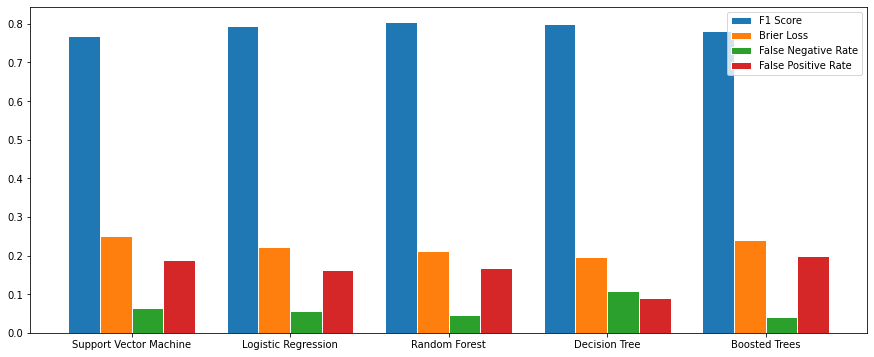

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 6)
barWidth = 0.20

xlabs = ["Support Vector Machine", "Logistic Regression", "Random Forest", "Decision Tree", "Boosted Trees"]

# Set position of bar on X axis
r1 = np.arange(len(f1_scores))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.bar(r1, f1_scores, width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r2, brier_scores, width=barWidth, edgecolor='white', label='Brier Loss')
plt.bar(r3, false_neg, width=barWidth, edgecolor='white', label='False Negative Rate')
plt.bar(r4, false_pos, width=barWidth, edgecolor='white', label='False Positive Rate')

# Add xticks on the middle of the group bars
plt.xticks([r + 1.5*barWidth for r in range(len(f1_scores))], xlabs)
plt.legend()
plt.show()


In [ ]:
# Random Forest
model_rf = RandomForestClassifier(random_state=2020)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred = (y_pred >= optimal_threshold).astype(int)

print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print("F1 = {}".format(f1_score(y_val, y_pred, average="weighted")))
print("Brier score = {}".format(brier_score_loss(y_val, y_pred)))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       950
           1       0.50      0.74      0.60       230

    accuracy                           0.81      1180
   macro avg       0.72      0.78      0.74      1180
weighted avg       0.85      0.81      0.82      1180

[[782 168]
 [ 60 170]]
F1 = 0.8193267123930021
Brier score = 0.19322033898305085


In [ ]:
num_features = 50
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:num_features]

In [ ]:
words = count_vect.get_feature_names()
print([words[i] for i in indices])

['terms', 'company', 'agreement', 'party', 'customer', 'fees', 'software', 'notice', 'services', 'state', 'damages', 'days', 'conditions', 'license', 'gsa', 'applicable', 'written', 'accordance', 'parties', 'rights', 'law', 'time', 'information', 'breach', 'use', 'right', 'payment', 'liability', 'date', 'licensee', 'expenses', 'entity', 'taxes', 'courts', 'subscription', 'end', 'order', 'contract', 'ordering', 'legal', 'event', 'activity', 'term', 'obligations', 'writing', 'section', 'termination', 'prior', 'policy', 'companys']
